# 机器学习作业:回归模型
- 姓名：卢麒萱
- 学号：2010519
- 专业：计算机科学与技术

- 回归是监督学习的一个重要问题，回归用于预测输入变量和输出变量之间的关系，特别是当输入变量的值发生变化时，输出变量的值也随之发生变化。
- 回归模型是一种表示从输入变量到输出变量之间映射的函数
- 对连续值的预测
- 可以用合适的曲线揭示样本点随着自变量的变化关系

### 实验要求
#### 基本要求：
将数据集winequality-white.csv按照4:1划分为训练集和测试集。
1. 构造线性回归模型，并采用批量梯度下降和随机梯度下降进行优化；输出训练集和测试集的均方误差（MSE），画出MSE收敛曲线。
2. 对于批量梯度下降和随机梯度下降，采用不同的学习率并进行MSE曲线展示，分析选择最佳的学习率。

特别需要注意：
- 划分数据集时尽可能保持数据分布的一致性，保持样本类别比例相似，可采用分层采样的方式。
- 需要对数据集进行一定的预处理

#### 中级要求：
探究回归模型在机器学习和统计学上的差异。
- 回归模型在机器学习领域和统计学领域中都十分常用，而且使用方法也相似，但其实际的含义具有本质的区别。我们希望同学们从回归模型的角度更加充分地理解机器学习和统计学的区别。

#### 高级要求：
编程实现岭回归算法，求解训练样本的岭回归模型，平均训练误差和平均测试误差（解析法、批量梯度下降法和随机梯度下降法均可）。

### 导入数据集和需要的包

In [85]:
import pandas as pd
import numpy as np
data = pd.read_csv("winequality-white.csv")
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


### 对数据集进行预处理

In [86]:
def Normalization(x):
    x = (x - np.min(x, 0)) / (np.max(x, 0) - np.min(x, 0))
    return x

def Standardization(x):
    return (x - np.mean(x, 0)) / np.std(x, 0)

# 提取特征和标签
# 所有行的0到最后第二列的数据，为特征
X = data.iloc[:, 0:-1]  #
X = Normalization(X)
print(X.shape)
#所有行的最后一列的数据为标签
Y = data.iloc[:, -1]

(4898, 11)


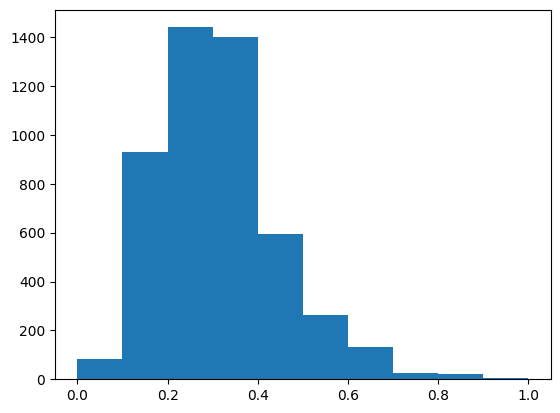

In [87]:
# 可视化中心化后的sulphates特征
import matplotlib.pyplot as plt
plt.hist(X["sulphates"])
plt.show()

In [88]:
# 这里注意一个小trick：回归系数会比特征x多一维，为了向量相乘方便，可以在训练集X左侧添加全为1的一列
data0 = pd.concat([pd.DataFrame(np.ones(X.shape[0]), columns=['x0']), X], axis=1)
data0
# 将索引随机打乱
row_indices=np.random.permutation(data0.shape[0])
# 查看打乱后的索引

data0=pd.concat([X,Y],axis=1)
data0.shape

(4898, 12)

In [89]:
#分层 随机 选取训练样本
def sample_split(data, train_ratio=0.8, label='quality', seed=None):
    xy_test=None
    # 根据分类标签分组
    xy_train = data.groupby(label).apply(lambda x: x.sample(frac=train_ratio, random_state=seed))
    
    # 将xy_train每行索引存入列表，为了找到在data中对应的行，删除得到test数据集
    list_index=[]
    for i in range(0,xy_train.shape[0]):
        list_index.append((xy_train.iloc[i].name)[1])
    xy_test=np.delete(data.values,list_index,axis=0)
    
    # 将训练集打乱顺序
    xy_train = xy_train.sample(frac=1, random_state=seed)
    xy_train.reset_index(drop=True, inplace=True)
    
    return xy_train, xy_test

# 训练集和测试集
train, test = sample_split(data0)
test=pd.DataFrame(test)
# 提取特征和标签
x_temp= train.iloc[:,:-1]
y=train.iloc[:, -1]

# 这里注意一个小trick：回归系数会比特征x多一维，为了向量相乘方便，可以在训练集X左侧添加全为1的一列
x_final = pd.concat([pd.DataFrame(np.ones(x_temp.shape[0]), columns=['x0']), x_temp], axis=1)
size, feature_num = x_final.shape

# 便于后续计算，将特征矩阵和分类结果都由dataframe转换为二维ndarray：
x_train= x_final.values
y_train = y.values.reshape(y.shape[0],1)
x = test.iloc[:,:-1]
y = test.iloc[:, -1]
x = pd.concat([pd.DataFrame(np.ones(x.shape[0]), columns=['x0']), x], axis=1)
test_x = x.values
test_y = y.values.reshape(y.shape[0],1)

In [90]:
# 初始化回归系数
W_init = np.random.rand(feature_num, 1)
W_init.reshape(feature_num)

array([0.12033116, 0.53005298, 0.48557893, 0.30577671, 0.51539151,
       0.09538449, 0.93283516, 0.84711034, 0.34956335, 0.67292336,
       0.10878372, 0.14719715])

In [91]:
import matplotlib.pyplot as plt

def compute_mse(x,y,theta):
    return np.mean((x@theta-y)**2)

#批量梯度下降
def gradient_descent_runner(x, y, theta, learning_ratio=0.01, max_iter=10000, change_ratio=1e-4, n_unchange=5):
    n_iter = 0
    no_change = 0
    mses = []
    random_mse=compute_mse(x,y,theta)
    mses.append(random_mse)
    # 停止条件：
    # 1.到达最大迭代次数
    # 2.边化率太小
    while n_iter < max_iter:
        n_iter += 1
        theta = learning_ratio/size * x.T@(y - x@theta) + theta 
        mse_temp = compute_mse(x,y,theta)
        if abs(mse_temp - mses[-1]) < change_ratio:
            no_change += 1
            if no_change >= n_unchange:
                break
        else:
            no_change = 0
        mses.append(mse_temp)
    return theta, mses


w_gd, mses_gd = gradient_descent_runner(x_train,y_train,W_init, learning_ratio=0.01, max_iter=1000, change_ratio=1e-19, n_unchange=5)
# mses_gd
print("批量梯度下降训练集mse：",mses_gd[-1])

批量梯度下降训练集mse： 0.7601427443892959


In [92]:
# 随机梯度下降
def rand_gradient_descent_runner(x, y, theta, learning_ratio=0.01, max_iter=10000, change_ratio=1e-6, n_unchange=5):
  n_iter = 0
  no_change = 0
  mses = []
  random_mse=compute_mse(x,y,theta)
  mses.append(random_mse)
  while n_iter < max_iter:
      n_iter += 1
      i = np.random.randint(size)
      tmp = (y[i] - x[i]@theta)
      theta = learning_ratio * x[i].reshape(feature_num,1)*tmp + theta
      mse_temp = compute_mse(x,y,theta)
      if abs(mse_temp - mses[-1]) < change_ratio:
          no_change += 1
          if no_change >= n_unchange:
              break
      else:
          no_change = 0
      mses.append(mse_temp)
  return theta, mses

w_sgd, mses_sgd = rand_gradient_descent_runner(x_train,y_train,W_init, learning_ratio=0.01, max_iter=1000, change_ratio=1e-4, n_unchange=5)
print("随机梯度下降训练集mse：",mses_sgd[-1])

随机梯度下降训练集mse： 0.8070001168401615


Text(0.5, 1.0, 'mse with different n_iters')

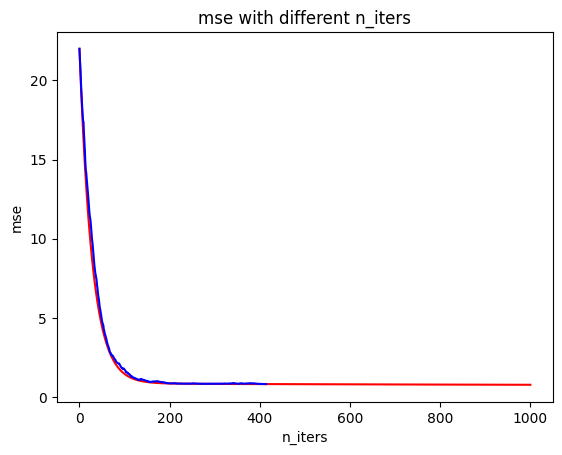

In [96]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
axes.plot(np.arange(len(mses_gd)), mses_gd, 'r')
axes.plot(np.arange(len(mses_sgd)), mses_sgd, 'b')
axes.set_xlabel('n_iters')
axes.set_ylabel('mse')
axes.set_title('mse with different n_iters')

Text(0.5, 1.0, 'mse with different n_iters')

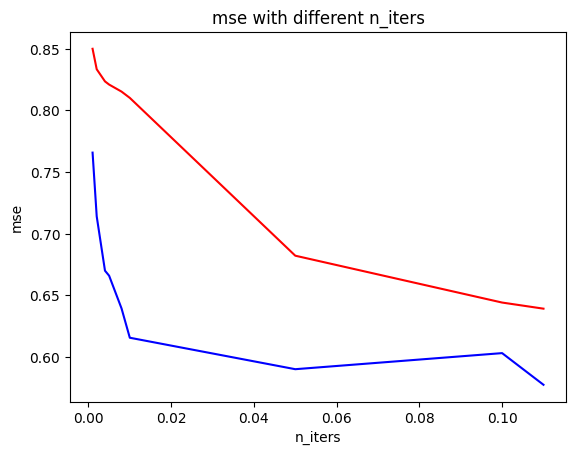

In [98]:
# learning_ratio_list=[0.001,0.005,0.01,0.05,0.1,0.3,0.5]
learning_ratio_list=(0.001,0.002,0.004,0.005,0.008,0.01,0.05,0.1,0.11)
gd_mses=[]
sgd_mses=[]
# gd_mses.append(compute_mse(x_train,y_train,W_init))    
# sgd_mses.append(compute_mse(x_train,y_train,W_init))

for l_r in learning_ratio_list:
    w_gd,mses = gradient_descent_runner(x_train,y_train,theta=W_init, learning_ratio=l_r)
    w_sgd,smses = rand_gradient_descent_runner(x_train,y_train,theta=W_init,learning_ratio=l_r)
    gd_mses.append(compute_mse(x_train,y_train,w_gd))    
    sgd_mses.append(compute_mse(x_train,y_train,w_sgd))
# gd_mses
sgd_mses
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
axes.plot(learning_ratio_list, gd_mses, 'r')
axes.plot(learning_ratio_list, sgd_mses, 'b')
axes.set_xlabel('n_iters')
axes.set_ylabel('mse')
axes.set_title('mse with different n_iters')

#### 回归模型在机器学习和统计学上的差异
机器学习模型旨在使最准确的预测成为可能；统计模型被设计用于推断变量之间的关系。

最明显的例子是线性回归。线性回归是一种统计方法，我们训练线性回归量并获得与统计回归模型相同的结果，旨在最小化数据点之间的平方误差。

在一个案例中，我们做了“训练”模型的事情，其中涉及使用数据的一个子集。我们不知道模型将如何执行，直到在训练期间能够“测试”出此数据不存在的、被称为测试集的其他数据。在这种情况下，机器学习的目的是在测试集上获得最佳性能。

对于统计模型，我们只要找出可以最小化所有数据的均方误差，无需训练，也无需测试。

一般在研究中，模型是表征数据与结果变量之间的关系，而不是对未来数据进行预测。我们将此过程称为统计推断，而不是机器学习预测。但我们仍然可以使用此模型进行预测，但评估模型的方式不涉及测试集，而是涉及评估模型参数的重要性和稳健性。

机器学习的目的是获得可以进行可重复预测的模型。我们通常不关心模型是否可解释，机器学习只看重结果。而统计建模更多的是发现变量之间的关系和这些关系的重要性，同时也适合预测。

In [100]:
# 岭回归求解回归参数
# 解析法
def compute_mse(x,y,theta):
    return np.mean((x@theta-y)**2)

def weights(x,y,lam=0.2):
    x_mat= np.mat(x)
    y_mat =np.mat(y)
    xtx=x_mat.T*x_mat
    rxtx = xtx+lam*np.eye(x_mat.shape[1])
    if np.linalg.det(rxtx) == 0.0:
        print("This matrix cannot do inverse, plz change lambda.")
        return 
    
    theta = rxtx.I*x_mat.T*y_mat
    return theta

w_t = weights(x_train,y_train)
# !!! 岭系数
w=np.asarray(w_t)
print(x_train.shape)
print(y_train.shape)
print("平均训练mse:")
print(compute_mse(x_train,y_train,w))
print("平均测试mse:")
print(compute_mse(test_x,test_y,w))


(3918, 12)
(3918, 1)
平均训练mse:
0.564304007337339
平均测试mse:
0.5647409131246914
